<a href="https://colab.research.google.com/github/jack-xu8/ai-vs-human-music-classification/blob/main/Ai_Human_Music_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing the Datasets for Classification

The goal of this section is to align formats of the datasets. In the first block, I try to find the keys of the .npz files and check the shapes to see if the files have comparable formats.

In [1]:
import numpy as np
import tensorflow as tf
# Function to inspect keys
def inspect_npz_keys(file_path):
    data = np.load(file_path, allow_pickle=True, encoding='latin1')
    print(f"Keys in {file_path}: {data.files}")
    for key in data.files:
        print(f"Key: {key}, Type: {type(data[key])}, Shape: {getattr(data[key], 'shape', 'N/A')}")

inspect_npz_keys('/content/datasets/Jsb16thSeparated.npz')
inspect_npz_keys('/content/datasets/js-fakes-16thSeparated.npz')
# Test out what a pitches chorale's shape is
jsf = np.load('/content/datasets/js-fakes-16thSeparated.npz', allow_pickle=True, encoding='latin1')
print("Example structure of a 'pitches' chorale:", type(jsf['pitches'][0]), jsf['pitches'][0].shape)
# Test out what a train chorale's shape is
jsb = np.load('/content/datasets/Jsb16thSeparated.npz', allow_pickle=True, encoding='latin1')
print("Example structure of a 'train' chorale:", type(jsb['train'][0]), jsb['train'][0].shape)

Keys in /content/datasets/Jsb16thSeparated.npz: ['test', 'train', 'valid']
Key: test, Type: <class 'numpy.ndarray'>, Shape: (77,)
Key: train, Type: <class 'numpy.ndarray'>, Shape: (229,)
Key: valid, Type: <class 'numpy.ndarray'>, Shape: (76,)
Keys in /content/datasets/js-fakes-16thSeparated.npz: ['pitches', 'chords']
Key: pitches, Type: <class 'numpy.ndarray'>, Shape: (500,)
Key: chords, Type: <class 'numpy.ndarray'>, Shape: (500,)
Example structure of a 'pitches' chorale: <class 'numpy.ndarray'> (128, 4)
Example structure of a 'train' chorale: <class 'numpy.ndarray'> (192, 4)


In this block, I try to combine the two datasets into different forms of data for my models. For the sequence based ones, I use sequences. For the 'simpler' models, I extract specific features to analyze.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Get singular arrays for each dataset
jsb_combined = np.concatenate([jsb['train'], jsb['valid'], jsb['test']])
jsf_pitches = jsf['pitches']

# Assign labels
y_jsb = ['Human'] * len(jsb_combined)
y_jsf = ['AI'] * len(jsf_pitches)

# Replace NaN with -1 in the JSB Chorales dataset for consistency with JS Fakes
jsb_combined = [np.nan_to_num(chorale, nan=-1) for chorale in jsb_combined]

# Combine data into sequences
jsb_combined = list(jsb_combined)
jsf_pitches = list(jsf_pitches)
X_sequences = jsb_combined + jsf_pitches
y_sequences = ['Human'] * len(jsb_combined) + ['AI'] * len(jsf_pitches)
label_encoder = LabelEncoder()

# Encode 'Human' as 1, and 'AI' as 0
y_encoded = label_encoder.fit_transform(y_sequences)

# Split for sequence based models
X_train_sequence, X_test_sequence, y_train_sequence, y_test_sequence = train_test_split(X_sequences, y_encoded, test_size=0.2, random_state=42)
X_train_ragged = tf.ragged.constant(X_train_sequence)
X_test_ragged = tf.ragged.constant(X_test_sequence)
max_length = 640
X_train_dense = X_train_ragged.to_tensor(default_value=0.0, shape=(None, max_length, 4))
X_test_dense = X_test_ragged.to_tensor(default_value=0.0, shape=(None, max_length, 4))
X_new_train_sequence, X_val_sequence, y_new_train_sequence, y_val_sequence = train_test_split(X_train_sequence, y_train_sequence, test_size=0.25, random_state=42)
X_new_ragged = tf.ragged.constant(X_new_train_sequence)
X_new_dense = X_new_ragged.to_tensor(default_value=0.0, shape=(None, max_length, 4))
X_val_ragged = tf.ragged.constant(X_val_sequence)
X_val_dense = X_val_ragged.to_tensor(default_value=0.0, shape=(None, max_length, 4))
y_new_train_sequence = tf.expand_dims(y_new_train_sequence, axis=-1)
y_val_sequence = tf.expand_dims(y_val_sequence, axis=-1)

# Feature extraction for feature based models
def extract_features(sequence):
    features = {}

    # Edge case handler (probably not necessary)
    if sequence.size == 0:
        return {key: 0 for key in [
            'silent_voices', 'average_pitch', 'pitch_range',
            'melodic_movement', 'parallel_motion',
            'voice_crossings', 'note_density',
            'rhythmic_variance', 'sustain_ratio', 'pitch_entropy'
        ]}

    # Silence
    total_elements = sequence.size
    silent_count = np.sum(sequence == -1)
    features['silent_voices'] = silent_count / total_elements

    # Pitch-related features
    valid_pitches = sequence[sequence != -1]
    if len(valid_pitches) > 0:
        features['average_pitch'] = np.mean(valid_pitches)
        features['pitch_range'] = np.max(valid_pitches) - np.min(valid_pitches)
    else:
        features['average_pitch'] = 0
        features['pitch_range'] = 0

    # Melodic movement
    diffs = np.diff(sequence, axis=0)
    melodic_movement = np.abs(diffs[sequence[1:] != -1])
    features['melodic_movement'] = np.mean(melodic_movement) if len(melodic_movement) > 0 else 0

    # Parallel motion
    prev_intervals = sequence[:-1, :, None] - sequence[:-1, None, :]
    curr_intervals = sequence[1:, :, None] - sequence[1:, None, :]
    valid_intervals = (sequence[:-1, :, None] != -1) & (sequence[:-1, None, :] != -1)
    parallel_motion = np.sum((prev_intervals == curr_intervals) & valid_intervals)
    total_valid_intervals = np.sum(valid_intervals)
    features['parallel_motion'] = parallel_motion / total_valid_intervals if total_valid_intervals > 0 else 0

    # Voice crossings
    valid_mask = (sequence != -1)
    crossings = np.sum((sequence[:, :, None] < sequence[:, None, :]) & valid_mask[:, :, None] & valid_mask[:, None, :])
    features['voice_crossings'] = crossings

    # Rhythmic features
    active_notes = np.sum(sequence != -1, axis=1)  # Active notes per timestep
    features['note_density'] = np.mean(active_notes)
    features['rhythmic_variance'] = np.std(active_notes)

    # Sustain ratios (vectorized)
    sustain_count = np.sum(sequence[1:] == sequence[:-1])
    features['sustain_ratio'] = sustain_count / total_elements

    # Pitch entropy
    if len(valid_pitches) > 0:
        unique_pitches, pitch_counts = np.unique(valid_pitches, return_counts=True)
        pitch_probs = pitch_counts / len(valid_pitches)
        features['pitch_entropy'] = -np.sum(pitch_probs * np.log2(pitch_probs))
    else:
        features['pitch_entropy'] = 0

    return features

X_features = [extract_features(seq) for seq in X_sequences]
X_features_df = pd.DataFrame(X_features)
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X_features_df, y_encoded, test_size=0.2, random_state=42)

# Implementing the Models

In this block, I implement a LSTM, RNN, and a GRU, or Gated Recurrent Unit. I also use a pretrained transformer just to see how well it can be adapted to this task

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, LSTM, GRU
from tensorflow.keras.models import Model
from transformers import TFAutoModel
from tensorflow.keras.metrics import AUC, F1Score

# Models
model_LSTM = Sequential([
    Input(shape=(max_length, 4)),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_RNN = Sequential([
    Input(shape=(max_length, 4)),
    SimpleRNN(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_GRU = Sequential([
    Input(shape=(max_length, 4)),
    GRU(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the models
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', F1Score(name='f1-score'), AUC(name='roc_auc')])
model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', F1Score(name='f1-score'), AUC(name='roc_auc')])
model_GRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', F1Score(name='f1-score'), AUC(name='roc_auc')])


In this block, I implement the feature based models:

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the models
k_NN = KNeighborsClassifier(n_neighbors=5)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)
logistic_regression = LogisticRegression(random_state=42)
naive_bayes = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)

In this block I implement a CNN

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

X_train_cnn = np.expand_dims(X_train_dense, axis=-1)
X_new_cnn = np.expand_dims(X_new_dense, axis=-1)
X_val_cnn = np.expand_dims(X_val_dense, axis=-1)
X_test_cnn = np.expand_dims(X_test_dense, axis=-1)
# CNN model
model_CNN = Sequential([
    Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the CNN
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='roc_auc'), F1Score(name='f1-score')])

In this block I do the initial training of the sequence based models, and track the training time and results

In [39]:
import time

# A function that trains a model and measures the training time
def train_time(model, train_dataset, val_dataset, epochs=10):
    start_time = time.time()
    try:
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            verbose=1
        )
    except Exception as e:
        print(f"Error during model.fit: {e}")
        return None, None  # Return None if fit fails

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")
    return history, training_time

#Train the models
train_dataset = tf.data.Dataset.from_tensor_slices((X_new_dense, y_new_train_sequence)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_dense, y_val_sequence)).batch(32)
for batch_x, batch_y in train_dataset.take(1):
    print("Input batch shape:", batch_x.shape)
    print("Target batch shape:", batch_y.shape)
print("Training LSTM...")
lstm_history, lstm_time = train_time(model_LSTM, train_dataset, val_dataset)
print("Training GRU...")
gru_history, gru_time = train_time(model_GRU, train_dataset, val_dataset)
print("Training RNN...")
rnn_history, rnn_time = train_time(model_RNN, train_dataset, val_dataset)

Input batch shape: (32, 640, 4)
Target batch shape: (32, 1)
Training LSTM...
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5754 - f1-score: 0.5956 - loss: 0.6896 - roc_auc: 0.4922 - val_accuracy: 0.5480 - val_f1-score: 0.6226 - val_loss: 0.6933 - val_roc_auc: 0.5063
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 848ms/step - accuracy: 0.5754 - f1-score: 0.5956 - loss: 0.6830 - roc_auc: 0.5021 - val_accuracy: 0.5480 - val_f1-score: 0.6226 - val_loss: 0.6919 - val_roc_auc: 0.4938
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 853ms/step - accuracy: 0.5754 - f1-score: 0.5956 - loss: 0.6839 - roc_auc: 0.5098 - val_accuracy: 0.5480 - val_f1-score: 0.6226 - val_loss: 0.6922 - val_roc_auc: 0.4938
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 858ms/step - accuracy: 0.5754 - f1-score: 0.5956 - loss: 0.6820 - roc_auc: 0.4619 - val_accuracy: 0.5480 - val_f1-score: 0.6226 - val_loss: 0.6948 - val_roc_auc: 0.5000
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - accuracy: 0.5754 - f1-score

In this block I do the initial training of the feature based models, and track the training time and results

In [40]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

models = [
    ("k-NN", k_NN),
    ("Random Forest", random_forest),
    ("SVM", svm),
    ("Logistic Regression", logistic_regression),
    ("Naive Bayes", naive_bayes),
    ("MLP", mlp),
    ("Decision Tree", decision_tree),
]
results = {}

# Train each model
for name, model in models:
    print(f"Training {name}...")

    # Measure training time
    start_time = time.time()
    model.fit(X_train_scaled, y_train_features)  # Train the model
    end_time = time.time()
    training_time = end_time - start_time

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    accuracy = accuracy_score(y_test_features, y_pred)
    f1 = f1_score(y_test_features, y_pred)
    roc_auc = roc_auc_score(y_test_features, y_pred_proba) if y_pred_proba is not None else None

    # Print the results
    results[name] = {
        "Accuracy": accuracy,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
        "Training Time (s)": training_time,
    }
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.3f}")
    else:
        print("ROC-AUC: Not available")
    print(f"Training Time: {training_time:.2f} seconds\n")

Training k-NN...
Accuracy: 0.780
F1-Score: 0.745
ROC-AUC: 0.830
Training Time: 0.00 seconds

Training Random Forest...
Accuracy: 0.831
F1-Score: 0.810
ROC-AUC: 0.901
Training Time: 0.30 seconds

Training SVM...
Accuracy: 0.763
F1-Score: 0.727
ROC-AUC: 0.860
Training Time: 0.11 seconds

Training Logistic Regression...
Accuracy: 0.740
F1-Score: 0.697
ROC-AUC: 0.836
Training Time: 0.02 seconds

Training Naive Bayes...
Accuracy: 0.661
F1-Score: 0.531
ROC-AUC: 0.795
Training Time: 0.00 seconds

Training MLP...
Accuracy: 0.814
F1-Score: 0.792
ROC-AUC: 0.879
Training Time: 2.78 seconds

Training Decision Tree...
Accuracy: 0.751
F1-Score: 0.728
ROC-AUC: 0.749
Training Time: 0.03 seconds



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In this block I do the initial training of the CNN, and track the training time and results

In [6]:
# Train the CNN
train_dataset = tf.data.Dataset.from_tensor_slices((X_new_cnn, y_new_train_sequence)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_sequence)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_sequence)).batch(32)
print("Training CNN(sequences)...")
cnn_history, cnn_time = train_time(model_CNN, train_dataset, val_dataset)


Training CNN(sequences)...


NameError: name 'train_time' is not defined

# Initial Results

This block is for creating a visual representation of the training results.

In [13]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

def evaluate_feature_models(models, X_test_features, y_test_features):
    results = {}
    for name, model in models.items():
        # Predict probabilities
        y_pred_probs = model.predict_proba(X_test_features)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test_features)
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test_features, y_pred)
        f1 = f1_score(y_test_features, y_pred)
        roc_auc = roc_auc_score(y_test_features, y_pred_probs)

        # Store results
        results[name] = {"Accuracy": accuracy, "F1-Score": f1, "ROC-AUC": roc_auc}
    return results

def evaluate_sequence_models(models, X_test_sequence, y_test_sequence):
    results = {}
    for name, model in models.items():
        # Predict probabilities
        y_pred_probs = model.predict(X_test_sequence)
        y_pred = (y_pred_probs >= 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test_sequence, y_pred)
        f1 = f1_score(y_test_sequence, y_pred)
        roc_auc = roc_auc_score(y_test_sequence, y_pred_probs)

        # Store results
        results[name] = {"Accuracy": accuracy, "F1-Score": f1, "ROC-AUC": roc_auc}
    return results

def evaluate_cnn_model(model, X_test_cnn, y_test_cnn):
    # Predict probabilities
    y_pred_probs = model.predict(X_test_cnn)
    y_pred = (y_pred_probs >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test_cnn, y_pred)
    f1 = f1_score(y_test_cnn, y_pred)
    roc_auc = roc_auc_score(y_test_cnn, y_pred_probs)
    # Store results
    results = {"Accuracy": accuracy, "F1-Score": f1, "ROC-AUC": roc_auc}
    return results

# Define the models
feature_based_models = {
    "k-NN": k_NN,
    "Random Forest": random_forest,
    "SVM": svm,
    "Logistic Regression": logistic_regression,
    "Naive Bayes": naive_bayes,
    "MLP": mlp,
    "Decision Tree": decision_tree
}
sequence_based_models = {
    "RNN": model_RNN,
    "LSTM": model_LSTM,
    "GRU": model_GRU,
}

#Find the results
feature_results = evaluate_feature_models(
    models=feature_based_models,
    X_test_features=X_test_scaled,
    y_test_features=y_test_features
)
sequence_results = evaluate_sequence_models(
    models=sequence_based_models,
    X_test_sequence=X_test_dense,
    y_test_sequence=y_test_sequence
)
cnn_results = evaluate_cnn_model(
    model=model_CNN,
    X_test_cnn=X_test_dense,
    y_test_cnn=y_test_sequence
)



# Combine results into a single dictionary
all_results = {**feature_results, **sequence_results, "CNN": cnn_results}
all_results_df = pd.DataFrame.from_dict(all_results, orient='index')

# Print the results
print(all_results_df)


# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.bar(all_results_df.index, all_results_df["Accuracy"], color="skyblue")
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot F1-Score
plt.figure(figsize=(10, 6))
plt.bar(all_results_df.index, all_results_df["F1-Score"], color="orange")
plt.title("Model F1-Score Comparison", fontsize=16)
plt.ylabel("F1-Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot ROC-AUC
plt.figure(figsize=(10, 6))
plt.bar(all_results_df.index, all_results_df["ROC-AUC"], color="green")
plt.title("Model ROC-AUC Comparison", fontsize=16)
plt.ylabel("ROC-AUC", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Combined Line Plot
plt.figure(figsize=(12, 8))
plt.plot(all_results_df.index, all_results_df["Accuracy"], marker="o", label="Accuracy", color="skyblue")
plt.plot(all_results_df.index, all_results_df["F1-Score"], marker="s", label="F1-Score", color="orange")
plt.plot(all_results_df.index, all_results_df["ROC-AUC"], marker="^", label="ROC-AUC", color="green")
plt.title("Model Metrics Comparison", fontsize=16)
plt.ylabel("Metric Value", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


NameError: name 'X_test_scaled' is not defined

# Hyperparameter Tuning

In this block I tune the hyperparameters for the feature based models to see if that will improve performance.

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Hyperparameter grids
param_grids = {
    "k-NN": {
        "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 150, 200],
        "max_depth": [None, 10, 15, 20, 25, 30],
        "min_samples_split": [2, 5, 10]
    },
    "MLP": {
        "hidden_layer_sizes": [(64,), (96,), (128,), (64, 32), (96, 32), (128, 64)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "sgd"],
        "alpha": [0.0001, 0.001, 0.01, 0.1]
    },
}

# Iterate through feature-based models
best_models = {}
tuning_results = {}
for name, model in feature_based_models.items():
    print(f"Tuning hyperparameters for {name}...")
    param_grid = param_grids.get(name, {})
    start_time = time.time()
    # GridSearch
    grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train_features, y_train_features)
    best_models[name] = grid_search.best_estimator_
    tuning_results[name] = {
        "Best Parameters": grid_search.best_params_,
        "Best ROC-AUC": grid_search.best_score_
    }
    end_time = time.time()
    tuning_time = end_time - start_time
    print(f"Tuning Time: {tuning_time:.2f} seconds\n")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best ROC-AUC: {grid_search.best_score_}\n")

# Evaluate the best models
final_results = {}

for name, model in best_models.items():
    print(f"Evaluating tuned {name}...")

    # Predict probabilities
    y_pred_probs = model.predict_proba(X_test_features)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test_features)
    y_pred = (y_pred_probs > 0.5).astype(int)
    # Calculate metrics
    accuracy = accuracy_score(y_test_features, y_pred)
    f1 = f1_score(y_test_features, y_pred)
    roc_auc = roc_auc_score(y_test_features, y_pred_probs)
    final_results[name] = {
        "Accuracy": accuracy,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }
    print(f"Tuned {name} - Accuracy: {accuracy:.3f}, F1-Score: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

Tuning hyperparameters for k-NN...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Tuning Time: 3.37 seconds

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Best ROC-AUC: 0.823230452674897

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Tuning Time: 118.00 seconds

Best Parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 150}
Best ROC-AUC: 0.9010288065843621

Tuning hyperparameters for SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning Time: 0.44 seconds

Best Parameters: {}
Best ROC-AUC: 0.6889711934156378

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning Time: 0.20 seconds

Best Parameters: {}
Best ROC-AUC: 0.778559670781893

Tuning hyperparameters for Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Tuning Time: 0.05 seconds

Best Parameters: {}
Best ROC-AUC: 0.8210493827160494

Tuning hyperparameters for MLP...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Tuning Time: 104.61 seconds

Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (96, 32), 'solver': 'adam'}
Best ROC-AUC: 0.7669547325102881

Tuning hyperparameters for Decision Tree...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning Time: 0.09 seconds

Best Parameters: {}
Best ROC-AUC: 0.7267901234567902

Evaluating tuned k-NN...
Tuned k-NN - Accuracy: 0.802, F1-Score: 0.783, ROC-AUC: 0.873
Evaluating tuned Random Forest...
Tuned Random Forest - Accuracy: 0.859, F1-Score: 0.839, ROC-AUC: 0.912
Evaluating tuned SVM...
Tuned SVM - Accuracy: 0.644, F1-Score: 0.462, ROC-AUC: 0.740
Evaluating tuned Logistic Regression...
Tuned Logistic Regression - Accuracy: 0.740, F1-Score: 0.697, ROC-AUC: 0.796
Evaluating tuned Naive Bayes...
Tuned Naive Bayes - Accuracy: 0.672, F1-Score

In this block, I will try to tune the hyperparameters of the sequence based models. It can be seen that all three models originally bottlenecked at a certain level and would not perform better, so I will only tune one of them, the GRU, which seemed to perform better than the RNN and around the same level as the LSTM, but slightly faster

In [9]:
!pip install keras_tuner

In [63]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam

# Function to define the model
def build_GRU(hpm, model_type="GRU"):
    model = Sequential()
    model.add(
        Dense(
            hpm.Int("units", min_value=32, max_value=128, step=32),
            activation="relu",
            input_shape=(X_train_dense.shape[1], X_train_dense.shape[2]),
        )
    )

    model.add(GRU(hpm.Int("recurrent_units", min_value=32, max_value=128, step=32)))
    model.add(Dropout(hpm.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(
        optimizer=Adam(hpm.Choice("learning_rate", values=[0.001, 0.01, 0.1])),
        loss="binary_crossentropy",
        metrics=['accuracy'],
    )
    return model

# Hyperparameter Tuning
tuner = kt.RandomSearch(
    lambda hpm: build_GRU(hpm, model_type="GRU"),
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="tuning_results",
    project_name="gru_hyperband_tuning",
)
X_train_dense
# Run the tuner
tuner.search(X_train_dense, y_train_sequence, epochs=10, validation_split=0.2, verbose=1)

# Get the best model
best_GRU_hpms = tuner.get_best_hyperparameters(num_trials=1)[0]
best_GRU = tuner.get_best_models(num_models=1)[0]
print("Best hyperparameters:", best_GRU_hpms.values)

Trial 10 Complete [00h 02m 07s]
val_accuracy: 0.5531914830207825

Best val_accuracy So Far: 0.5531914830207825
Total elapsed time: 00h 27m 18s
Best hyperparameters: {'units': 96, 'recurrent_units': 96, 'dropout': 0.30000000000000004, 'learning_rate': 0.01}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In this block, I will try to tune the hyperparameters of the CNN to see if there are any performance improvements.

In [12]:
def build_cnn(hpm):
    model = Sequential()
    kernel_size = eval(hpm.Choice("kernel_size", values=["(3, 3)", "(5, 5)"]))
    model.add(
        Conv2D(
            filters=hpm.Int("filters", min_value=16, max_value=64, step=16),
            kernel_size=kernel_size,
            activation="relu",
            input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], X_train_cnn.shape[3]),
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hpm.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(hpm.Int("dense_units", min_value=64, max_value=256, step=64), activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(hpm.Choice("learning_rate", values=[0.001, 0.01, 0.1])),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Hyperparameter Tuning
cnn_tuner = kt.RandomSearch(
    build_cnn,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="tuning_results",
    project_name="cnn_model_tuning",
)

# Run the tuner
cnn_tuner.search(X_train_dense, y_train_sequence, epochs=10, validation_split=0.2, verbose=1)

# Get the best CNN model
best_cnn_hps = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]
best_cnn = cnn_tuner.get_best_models(num_models=1)[0]
print("Best hyperparameters for CNN:", best_cnn_hps.values)

Trial 2 Complete [00h 00m 02s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 04s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
(5, 5)            |(5, 5)            |kernel_size
64                |64                |filters
0.5               |0.1               |dropout
128               |128               |dense_units
0.001             |0.01              |learning_rate

Epoch 1/10


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv2D.call().

[1mNegative dimension size caused by subtracting 5 from 4 for '{{node sequential_1/conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](data, sequential_1/conv2d_1/convolution/ReadVariableOp)' with input shapes: [?,640,4,1], [5,5,1,64].[0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(None, 640, 4, 1), dtype=float32)


# Final Evaluations

After the initial training, it was seen that the sequence-based models fell far behind both the feature-based models and the CNN. The Random Forest model outcompeted every other feature-based model to varying degrees, besides maybe the MLP, and provided the same level of discerment as the CNN, while being extremely fast to train in comparison to both the MLP and especially the CNN. After the hyperparameter tuning, these are the new results.

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
GRU Results: {'Accuracy': 0.536723163841808, 'F1-Score': 0.0, 'ROC-AUC': 0.49473684210526314}
CNN Results: {'Accuracy': 0.8361581920903954, 'F1-Score': 0.8176100628930818, 'ROC-AUC': 0.9029525032092427}
           Model  Accuracy  F1-Score   ROC-AUC
0  Random Forest  0.847458  0.830189  0.907445
1            GRU  0.536723  0.000000  0.494737
2            CNN  0.836158  0.817610  0.902953


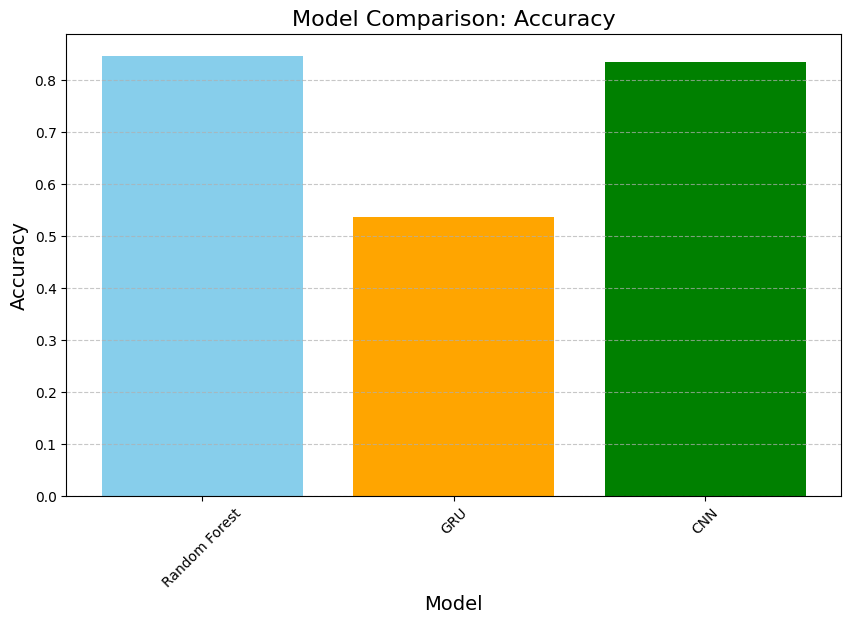

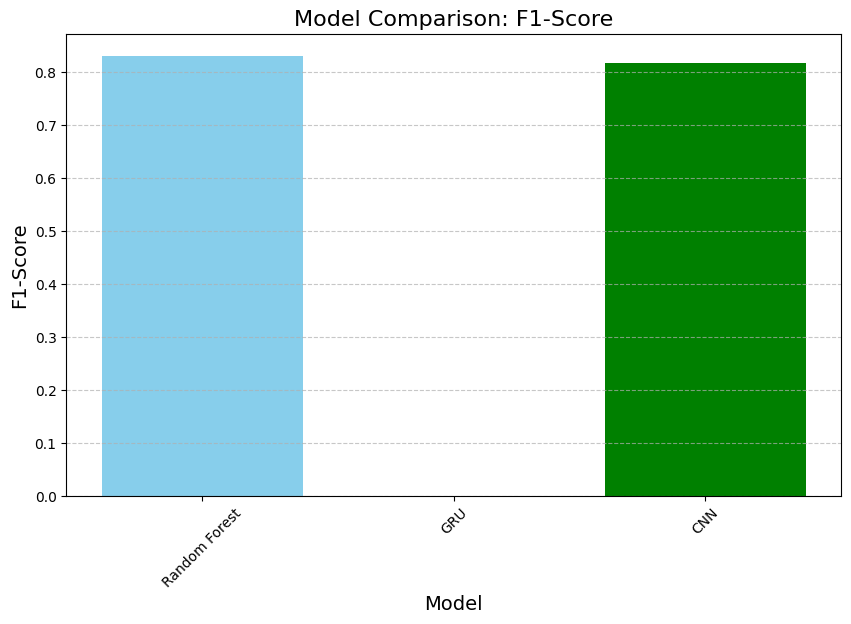

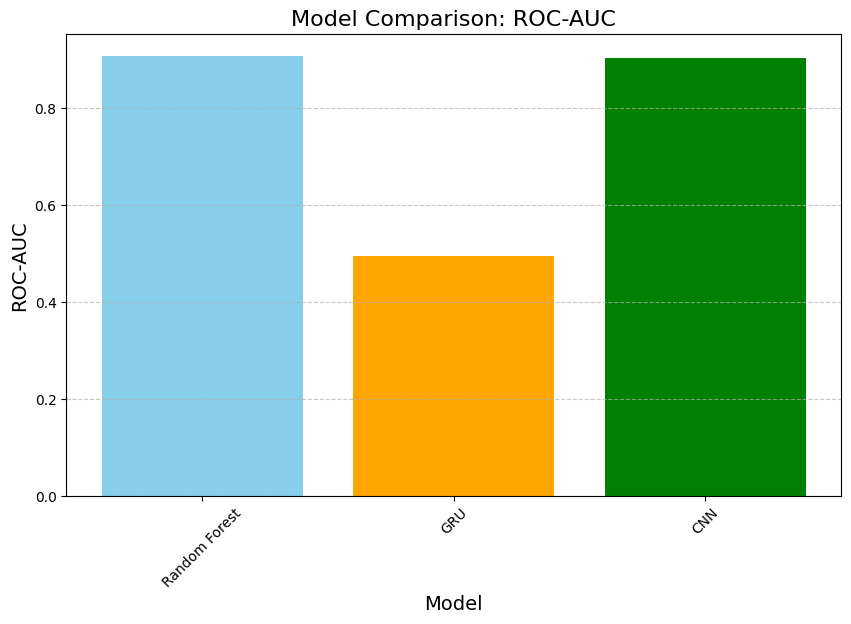

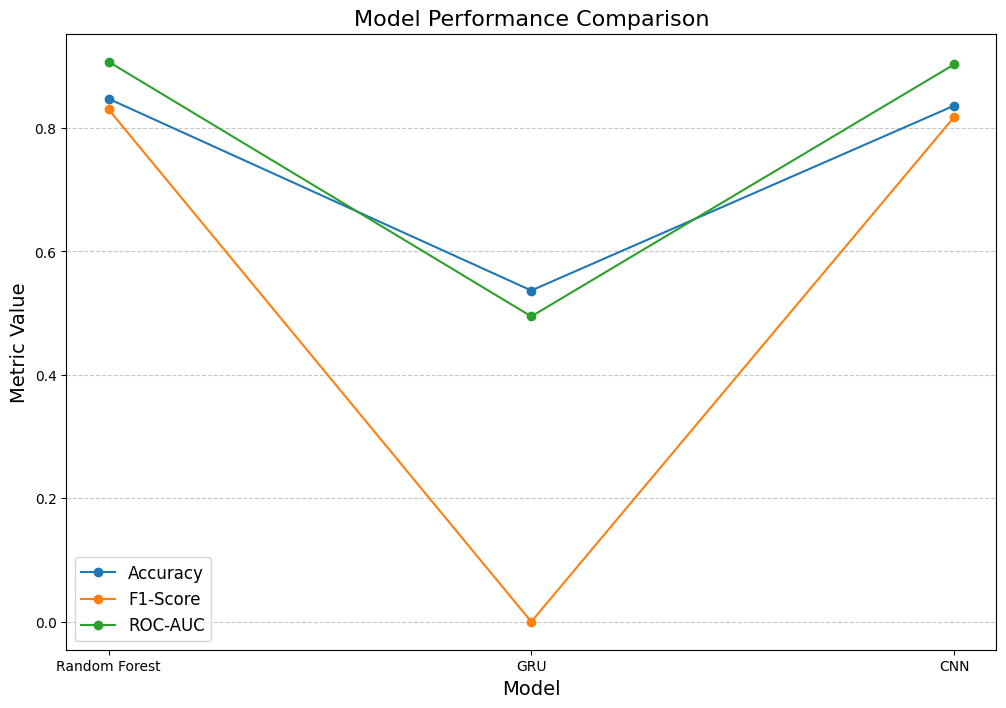

In [66]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# Find the best feature-based model based on ROC-AUC
feature_results_df = pd.DataFrame.from_dict(final_results, orient="index")
best_model_name = feature_results_df["ROC-AUC"].idxmax()
tuned_feature_model = best_models[feature_results_df["ROC-AUC"].idxmax()]

# Evaluate GRU
gru_results = {}
y_pred_probs_gru = best_GRU.predict(X_test_dense)
y_pred_gru = (y_pred_probs_gru > 0.5).astype(int)
gru_results["Accuracy"] = accuracy_score(y_test_sequence, y_pred_gru)
gru_results["F1-Score"] = f1_score(y_test_sequence, y_pred_gru)
gru_results["ROC-AUC"] = roc_auc_score(y_test_sequence, y_pred_probs_gru)

# Evaluate CNN
cnn_results = {}
y_pred_probs_cnn = best_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_probs_cnn > 0.5).astype(int)
cnn_results["Accuracy"] = accuracy_score(y_test_sequence, y_pred_cnn)
cnn_results["F1-Score"] = f1_score(y_test_sequence, y_pred_cnn)
cnn_results["ROC-AUC"] = roc_auc_score(y_test_sequence, y_pred_probs_cnn)

print("GRU Results:", gru_results)
print("CNN Results:", cnn_results)

# Combine results
comparison_results = pd.DataFrame({
    "Model": [best_model_name, "GRU", "CNN"],
    "Accuracy": [
        feature_results_df.loc[best_model_name, "Accuracy"],
        gru_results["Accuracy"],
        cnn_results["Accuracy"]
    ],
    "F1-Score": [
        feature_results_df.loc[best_model_name, "F1-Score"],
        gru_results["F1-Score"],
        cnn_results["F1-Score"]
    ],
    "ROC-AUC": [
        feature_results_df.loc[best_model_name, "ROC-AUC"],
        gru_results["ROC-AUC"],
        cnn_results["ROC-AUC"]
    ]
})

print(comparison_results)

# Plot the metrics and models
metrics = ["Accuracy", "F1-Score", "ROC-AUC"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_results["Model"], comparison_results[metric], color=["skyblue", "orange", "green"])
    plt.title(f"Model Comparison: {metric}", fontsize=16)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plt.figure(figsize=(12, 8))
for metric in metrics:
    plt.plot(comparison_results["Model"], comparison_results[metric], marker="o", label=metric)

plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Metric Value", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

